# Getting started with exploratory data analysis

## Install and import required libraries

In [4]:
%bash
pip install sns

### NOTE 
Run below cell whenever you restart the session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import google.datalab.bigquery as bq
import google.datalab.storage as storage
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

## Sampling data using bigquery

First check total number of rows we have in our table.

In [3]:
%bigquery execute -d standard
SELECT COUNT(DEP_DELAY) FROM flights.simevents

f0_
2209776


We will use [RAND](https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators#rand) to get random sample from uniformely distributed dataset.
Lets check how accurate the query is.

In [71]:
%bigquery execute -d standard 
SELECT COUNT(*) FROM flights.simevents WHERE RAND() < 0.01

f0_
22117


Looks quite accurate. Try with the code now.
Our goal is to find the 30% chance of arrival delay is 15 min late. From chapter 3 that is departure delay of 10 min .
Will look into more depth with arrival delay for datasets that has departure delay larger than 10 min.

In [6]:
# 

sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE DEP_DELAY > 10 AND RAND() < 0.01
"""

df = bq.Query(sql).execute().result().to_dataframe()
df.describe()

,ARR_DELAY,DEP_DELAY
count,1696.000000,1703.000000
mean,-8.790094,-2.825602
std,14.193963,4.820954
min,-57.000000,-24.000000
25%,-17.000000,-6.000000
50%,-10.000000,-3.000000
75%,-2.000000,0.000000
max,118.000000,9.000000


## Check probability distribution for arrival delay using violin plot.

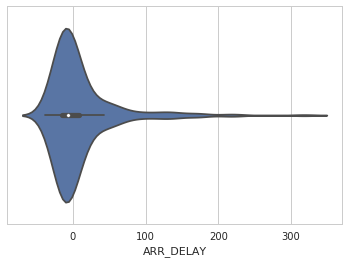

In [9]:
sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

## Explore arrival delays
Here, I will compare the probability for arrival delay between datasets that has less than 10 min delay and more than 10 min delay.

(-50, 200)

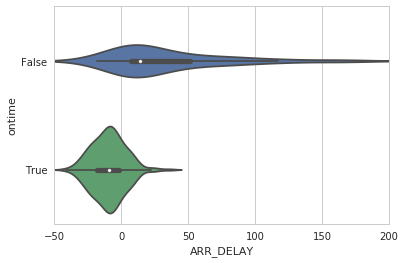

In [4]:
# Pull random 1% sample from the dataset

sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.fedtzcorr`
WHERE RAND() < 0.001
"""

df = bq.Query(sql).execute().result().to_dataframe()

# Threshold comparison will be done in the code.
# Mark column "ontime" as TRUE when the departure delay is less than 10 min
df['ontime'] = df['DEP_DELAY'] < 10

sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

## Add quality control
Here, I will explore how arrival delays are distributed against departure delay.

In [26]:
%bigquery execute -d standard
SELECT
  DEP_DELAY as dep_delay_in_minutes,
  AVG(ARR_DELAY) AS arrival_delay_in_minutes,
  COUNT(ARR_DELAY) AS numflights,
FROM flights.simevents
GROUP BY DEP_DELAY
ORDER BY DEP_DELAY

dep_delay_in_minutes,arrival_delay_in_minutes,numflights,max
,-9.70798319327731,952,
-50.0,-38.0,2,-50.0
-49.0,-59.5,4,-49.0
-46.0,-28.5,4,-46.0
-45.0,-44.0,4,-45.0
-43.0,-53.0,4,-43.0
-42.0,-35.0,6,-42.0
-40.0,-26.0,4,-40.0
-39.0,-33.5,4,-39.0
-38.0,-21.5,4,-38.0


In [27]:
%bigquery execute -d standard
SELECT
  MAX(DEP_DELAY) AS dep,
FROM flights.simevents

dep
2007.0


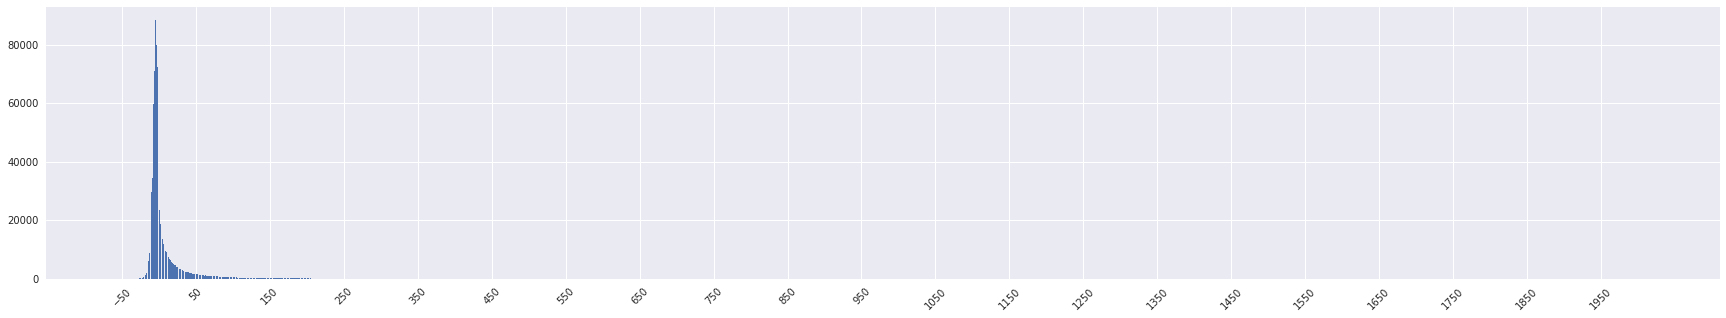

In [53]:
sql="""
SELECT
  DEP_DELAY as dep_delay_in_minutes,
  AVG(ARR_DELAY) AS arrival_delay_in_minutes,
  COUNT(ARR_DELAY) AS numflights
FROM flights.simevents
WHERE DEP_DELAY IS NOT NULL
GROUP BY DEP_DELAY
ORDER BY DEP_DELAY
"""

df = bq.Query(sql).execute().result().to_dataframe()

# By bar in pyplot
plt.figure(figsize=(30.0,5.0))
plt.bar(df['dep_delay_in_minutes'], df['numflights'])
plt.xticks(np.arange(-50, 2000, step=100),rotation=45)

# Seaborn barplot
#ax = sb.barplot(data=df, x='dep_delay_in_minutes', y='numflights', order=df['dep_delay_in_minutes'])
#ax.set_xlim(0.0, )
#ax.figure.set_figwidth(30)

# Set properties
#labels = ax.get_xticklabels()
#plt.setp(labels,rotation=45)

# Adjust xtick frequency
#plt.xticks(np.arange(df['dep_delay_in_minutes'].min(), df['dep_delay_in_minutes'].max()+1, 50.0))

plt.show()

## Find oddball values and outliers
It is obvious that most of departure time has few number of flights which means these are odd values (outliers).   
To have accurate data model , I will need to exclude the ouliers .  

Use three sigma rule to see the how departure delay lies on the edge .  
https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

In [10]:
%bigquery execute -d standard
SELECT
  AVG(DEP_DELAY)-3*STDDEV(DEP_DELAY) AS flights_min,
  AVG(DEP_DELAY)+3*STDDEV(DEP_DELAY) AS flights_max
FROM  flights.simeventsb

flights_min,flights_max
-129.16468072713647,148.08107768320795


Above assumes that samples are Gaussian . If not, perhaps we use pecentile .

In [7]:
%bigquery execute -d standard
SELECT
  APPROX_QUANTILES(DEP_DELAY, 20) as ventiles
FROM  flights.simevents

ventiles
"[-50.0, -11.0, -9.0, -8.0, -7.0, -6.0, -5.0, -5.0, -4.0, -3.0, -3.0, -2.0, -1.0, 0.0, 2.0, 6.0, 11.0, 20.0, 35.0, 71.0, 2007.0]"


However, filtering out input data might lose  valuable "nuance". Thus, I will observe on frequency of certain value.

## Find data by occurence frequency

I have decided to use the threshold for frequency as sigma 3.

1 - 99.73 % + 0.27 % 

This 0.27% can be considered as 'outliers' .

0.0027 = 1 / N ( <= 1 in N will be out of the population .)
N = 1 / 0.0027 
  = 1 / 370
  
So numflights that does not satisfy frequency of 370 will be treated as outliers .

In [20]:
%bigquery execute -d standard
SELECT
  DEP_DELAY,
  AVG(ARR_DELAY) AS arrival_delay,
  STDDEV(ARR_DELAY) AS stddev_arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.simevents`
GROUP BY
  DEP_DELAY
HAVING
  numflights > 370
ORDER BY
  DEP_DELAY

DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
,-9.70798319327731,16.382674651465933,952
-21.0,-25.323886639676108,15.112571378380206,494
-20.0,-23.330788804071233,14.52140940462532,786
-19.0,-22.87524366471735,13.537879330598196,1026
-18.0,-23.313475177304966,14.106545902924173,1410
-17.0,-21.516393442622952,13.606678859658217,1952
-16.0,-21.15179198875614,13.462157151466316,2846
-15.0,-20.160142348754416,13.513036572106477,4496
-14.0,-19.360919540229865,13.20458608161916,6090
-13.0,-18.652736770383836,13.407313509484487,8806


In [27]:
thresholds = [ 5, 10, 22, 100, 200, 300, 370, 500, 1000 ]
total_records = 2209776

sql = """
SELECT
  {} - SUM(numflights) AS num_removed,
  AVG(arrival_delay * numflights)/AVG(DEP_DELAY * numflights) AS lm
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.simevents`
  GROUP BY
    DEP_DELAY
  ORDER BY
    DEP_DELAY )
WHERE numflights > {}
"""

for t in sorted( thresholds, reverse=True):
    df = bq.Query(sql.format(total_records, t)).execute().result().to_dataframe()
    print('{:>12} {:>12} {:.2f}'.format( t, df['num_removed'][0],  df['lm'][0] ))

        1000      1168692 -2.87
         500      1143060 -0.90
         370      1133926 -0.53
         300      1130270 -0.41
         200      1123638 -0.20
         100      1116104 -0.00
          22      1109912 0.17
          10      1108772 0.20
           5      1107844 0.24


## (DOING) Conditioning arrival delay based on departure delay

## (TODO) Apply probalistic decision threshold


## (TODO) Apply empirical probability distribution function

## (TODO) Evaluate model

## (TODO) Train and test